## Автоэнкодер для очистки изображений от шумов / Denoising Autoencoder 

Необходимо обучить автоэнкодер для очискти изображений документов от шумов. 

Ссылка на соревнование на `kaggle`: https://www.kaggle.com/c/denoising-dirty-documents/data

In [ ]:
!unzip '/content/train.zip'
!unzip '/content/test.zip'
!unzip '/content/train_cleaned.zip'

# 1. Импортируем библиотеки для создания нейросети и визуализации изображений. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import os
from torchvision.utils import save_image
import imageio

In [ ]:
import tqdm

In [ ]:
import pandas as pd

In [ ]:
import cv2

In [ ]:
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
print(device)

cuda


In [ ]:
train_dir = "/content/train_"
test_dir = "/content/test_"
train_clnd_dir = "/content/train_cleaned_"

In [ ]:
transform = transforms.Compose([
                              transforms.Resize((300, 300)),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.ToTensor()                       
                               ])

# 2. Загружаем данные

In [ ]:
train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(train_clnd_dir, transform)
test_set = datasets.ImageFolder(test_dir, transform)

In [ ]:
batch_size=8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, drop_last=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, drop_last=False)

In [ ]:
# store image names in list for later use
train_img = sorted(os.listdir(train_dir + '/train'))
train_cleaned_img = sorted(os.listdir(train_clnd_dir + '/train_cleaned'))
test_img = sorted(os.listdir(test_dir + '/test'))

In [ ]:
test_img

# 3. Распечатаем один и тот же документ в двух версиях: зашумленной и очищенной. 

In [ ]:
next(iter(train_loader))[0][0].shape

torch.Size([1, 128, 128])

In [ ]:
next(iter(train_loader))[0][0].squeeze(0)

tensor([[0.9137, 0.9216, 0.9176,  ..., 0.9137, 0.9059, 0.9098],
        [0.9020, 0.8941, 0.8941,  ..., 0.9137, 0.9255, 0.9176],
        [0.8667, 0.8824, 0.8941,  ..., 0.9020, 0.9176, 0.9255],
        ...,
        [0.8510, 0.8392, 0.8667,  ..., 0.8706, 0.8667, 0.8863],
        [0.8706, 0.8784, 0.8824,  ..., 0.8980, 0.8667, 0.8353],
        [0.9098, 0.8902, 0.8902,  ..., 0.8235, 0.5216, 0.3176]])

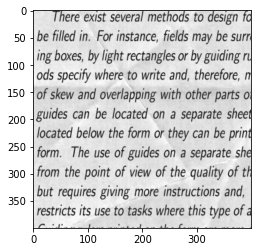

In [ ]:
plt.imshow(next(iter(train_loader))[0][0].squeeze(0), cmap='gray')

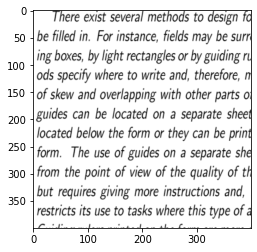

In [ ]:
plt.imshow(next(iter(valid_loader))[0][0].squeeze(0), cmap='gray')

In [ ]:
next(iter(test_loader))[0][0].shape

torch.Size([1, 128, 128])

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 144
    Root location: /content/train_
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
img  = cv2.imread('/content/test_/test/97.png', 0)
img

array([[225, 231, 233, ..., 225, 226, 226],
       [232, 232, 231, ..., 227, 228, 231],
       [233, 230, 227, ..., 228, 229, 222],
       ...,
       [220, 221, 220, ..., 223, 224, 226],
       [221, 223, 217, ..., 230, 211, 202],
       [228, 230, 223, ..., 131,  69,  37]], dtype=uint8)

In [ ]:
output[1].squeeze(0).squeeze(0).squeeze(0)

tensor([[0.8566, 0.9026, 0.9321,  ..., 0.9249, 0.9516, 0.9317],
        [0.9107, 0.9953, 1.0337,  ..., 0.9567, 0.9843, 0.9955],
        [0.9208, 0.9952, 1.0156,  ..., 0.8229, 0.7753, 0.9065],
        ...,
        [0.9240, 0.9954, 1.0413,  ..., 1.0065, 0.9521, 1.0067],
        [0.9217, 0.9910, 1.0535,  ..., 0.9847, 0.9559, 1.0174],
        [0.8932, 0.9286, 0.9822,  ..., 0.8846, 0.8840, 0.9548]],
       grad_fn=<SqueezeBackward1>)

# 5. Распечатаем `shape` получившихся наборов данных.  

In [ ]:
next(iter(test_loader))[0][0].shape

torch.Size([1, 128, 128])

In [ ]:
next(iter(train_loader))[0][0].shape

torch.Size([1, 128, 128])

In [ ]:
(next(iter(train_loader))[0][3][2]== next(iter(train_loader))[0][1][1])#.detach().numpy().isnull()

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False,  True, False,  ...,  True, False, False]])

# 6. Задаем сверточный энкодер.

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU() #гладкая в отличие от RELU
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )

        self.pool = nn.MaxPool2d(2, 2, return_indices=True) 

        self.unpool = nn.MaxUnpool2d(2, 2) 

        self.conv1_t = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv2_t = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv3_t = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3,padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )

    

    def forward(self, x):
        # encode
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x, indicies = self.pool(x) # ⟸ bottleneck  тюпл
        # print(f'bottleneck shape: {x.shape}')
        # decode
        x = self.unpool(x, indicies)
        x = self.conv1_t(x)
        x = self.conv2_t(x)
        x = self.conv3_t(x)

        return x


model = ConvAutoencoder().to(device)
summary(model, (1, 128, 128), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 128, 128]             320
       BatchNorm2d-2          [1, 32, 128, 128]              64
              SELU-3          [1, 32, 128, 128]               0
            Conv2d-4          [1, 16, 128, 128]           4,624
       BatchNorm2d-5          [1, 16, 128, 128]              32
              SELU-6          [1, 16, 128, 128]               0
            Conv2d-7           [1, 4, 128, 128]             580
       BatchNorm2d-8           [1, 4, 128, 128]               8
              SELU-9           [1, 4, 128, 128]               0
        MaxPool2d-10  [[-1, 4, 64, 64], [-1, 4, 64, 64]]               0
      MaxUnpool2d-11           [1, 4, 128, 128]               0
  ConvTranspose2d-12          [1, 16, 128, 128]             592
      BatchNorm2d-13          [1, 16, 128, 128]              32
             SELU-14          

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
model = ConvAutoencoder().to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())#, lr=0.001)

lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.05)

In [ ]:
model.to(device)

ConvAutoencoder(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_t): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

# 10. Обучение автоэнкодера 

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
rec_images[7].squeeze(0).detach().cpu().shape

torch.Size([300, 300])

epoch 0 started ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


epoch loss: 0.0038256365805864334


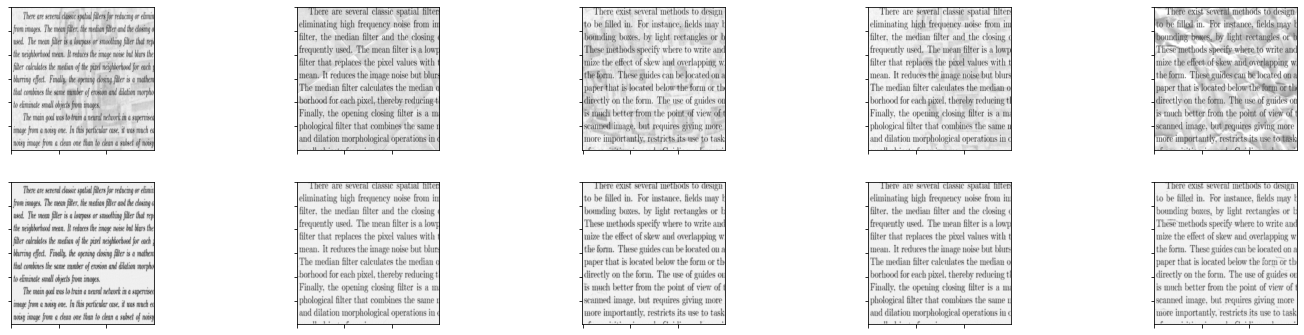

epoch 1 started ...
epoch loss: 0.00295307207852602
epoch 2 started ...
epoch loss: 0.0026013434398919344
epoch 3 started ...
epoch loss: 0.0035152826458215714
epoch 4 started ...
epoch loss: 0.002717363415285945
epoch 5 started ...
epoch loss: 0.002441530581563711


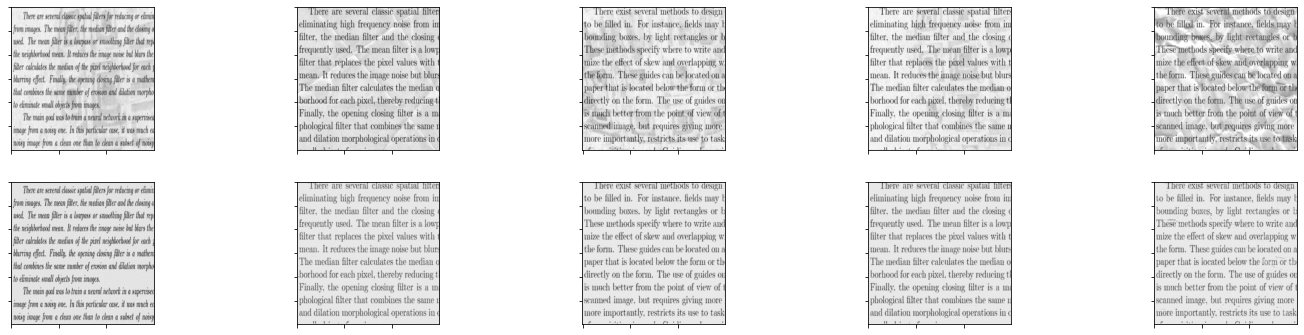

epoch 6 started ...
epoch loss: 0.002491062507033348
epoch 7 started ...
epoch loss: 0.0023686522617936134
epoch 8 started ...
epoch loss: 0.0032408495899289846
epoch 9 started ...
epoch loss: 0.0033356077037751675
epoch 10 started ...
epoch loss: 0.004114597104489803


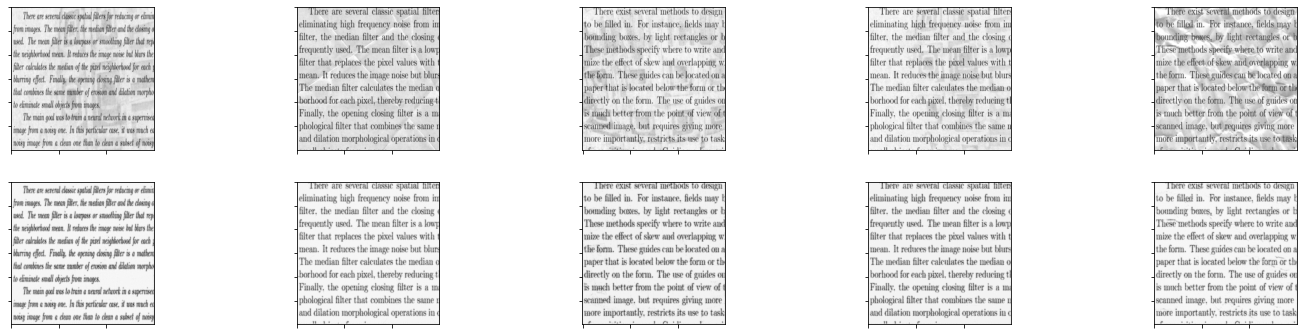

epoch 11 started ...
epoch loss: 0.003149191616103053
epoch 12 started ...
epoch loss: 0.0023255390115082264
epoch 13 started ...
epoch loss: 0.0033023522701114416
epoch 14 started ...
epoch loss: 0.002737746573984623
epoch 15 started ...
epoch loss: 0.002468342427164316


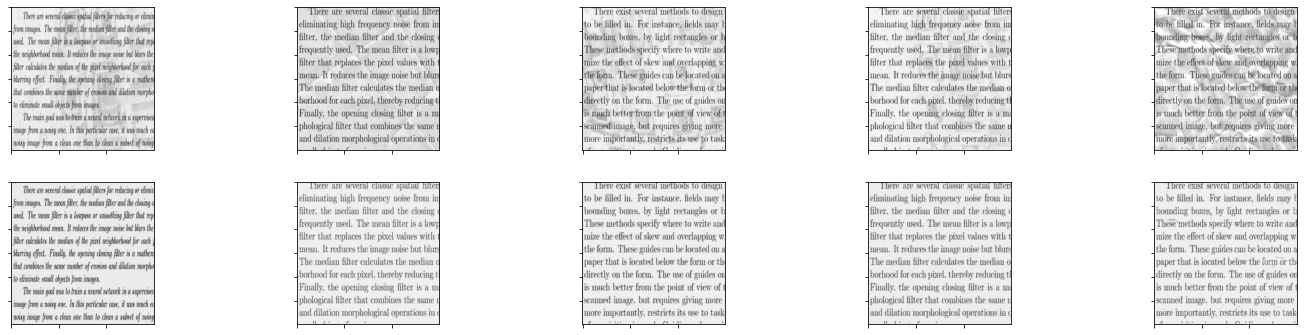

epoch 16 started ...
epoch loss: 0.0024722188245505095
epoch 17 started ...
epoch loss: 0.0021952399984002113
epoch 18 started ...
epoch loss: 0.003170390147715807
epoch 19 started ...
epoch loss: 0.0030125807970762253
epoch 20 started ...
epoch loss: 0.002834230661392212


KeyboardInterrupt: ignored

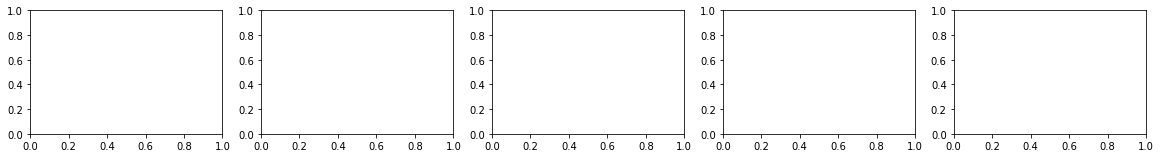

In [ ]:
n_epochs = 100
epoch_loss = []

model.train()

for epoch in np.arange(n_epochs):

  print(f'epoch {epoch} started ...')
  for  (images, _), (labels, _) in zip(train_loader, valid_loader):
    # print(f'batch No is {batch_num}')
    batch_loss = []
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    # with torch.no_grad():
    rec_images = model(images)
    
    # print(f'images shape: {images.shape}')
    # print(f'rec_images shape: {rec_images.shape}')

    loss = criterion(rec_images, labels)

    loss.backward()
    optimizer.step()
    lr_sched.step()

    batch_loss.append(loss.item())

    # print(f'batch loss {batch_loss[-1]}')

  epoch_loss.append(np.mean(batch_loss))
  print(f'epoch loss: {epoch_loss[-1]}')

  if epoch % 5 == 0:
    # lrs.append(optimizer.param_groups[0]["lr"])
    # print(f'Epoch: {epoch} \tTraining Loss: {train_loss_batch:.6f} \tlr:{optimizer.param_groups[0]["lr"]:.3f}')
    # save_image(rec_images.detach().cpu(), f'results/img{epoch}.jpg')
  
    fig, ax = plt.subplots(2, 5, figsize=(20, 5))
    fig.tight_layout()
    ax = ax.flatten()
    for pos in range(10):
      if pos < 5:
        ax[pos].imshow(images[pos].squeeze(0).detach().cpu(), cmap='gray')
        ax[pos].set_yticklabels([]); ax[pos].set_xticklabels([])
      else:
        ax[pos].imshow(rec_images[pos-5].squeeze(0).detach().cpu(), cmap='gray')
        ax[pos].set_yticklabels([]); ax[pos].set_xticklabels([])
        # plt.subplots_adjust(wspace=0, hspace=-.1)
    plt.show();
  #   torch.cuda.empty_cache()

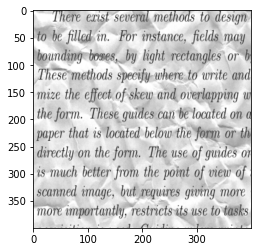

In [ ]:
plt.imshow(images[3].squeeze(0).detach().cpu(), cmap='gray')

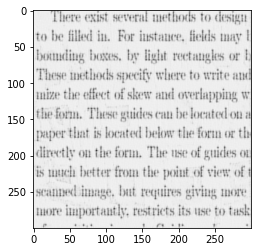

In [ ]:
plt.imshow(rec_images[2].squeeze(0).detach().cpu(), cmap='gray')

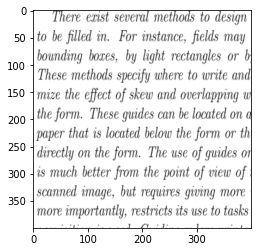

In [ ]:
plt.imshow(labels[3].squeeze(0).detach().cpu(), cmap='gray')

# 11. Сделаем предсказания на тестовой выборке. 

In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, _ = dataiter.next()

model.eval()

#Sample outputs
output = model(images.cuda())
images = images.cpu()

# output = output.view(batch_size, 3, 32, 32)
output = output.cpu()



Original Images
Reconstructed Images


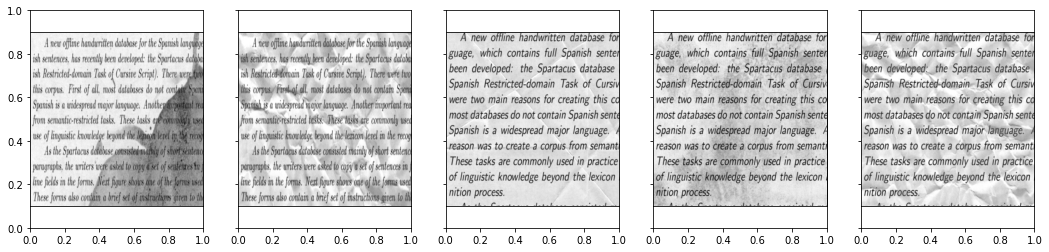

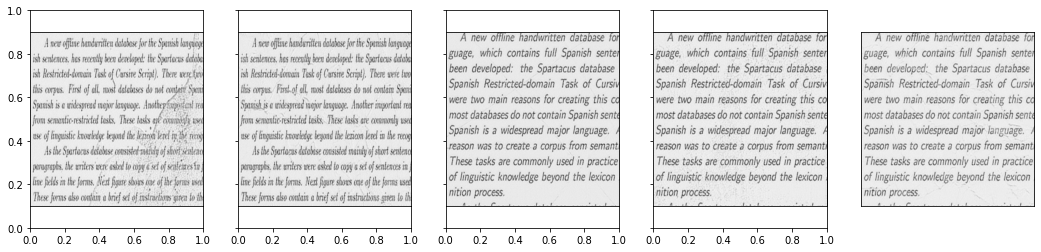

In [ ]:
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(18,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    # plt.imshow(torch.permute(images[idx], (1, 2, 0)))
    plt.imshow(images[idx].squeeze(0), cmap='gray')
    # ax.set_title(classes[labels[idx]])
# plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(18,4))
plt.axis('off')
for idx in np.arange(5):
    ax.grid(False)
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx].squeeze(0).detach().cpu(), cmap='gray')
    # ax.set_title(classes[labels[idx]])
    
# plt.show() 

In [ ]:
output

12. Заполним файл с предсказаниями в соответствии с требованиями: https://www.kaggle.com/c/denoising-dirty-documents/overview/evaluation

In [ ]:
import torchvision

In [ ]:
id = []
value = []
def read_and_preprocess_image(img):
    img = torchvision.io.read_image(img)/255
    img=img.cuda()
    img = img.unsqueeze(0)
    return img

test_names = os.listdir('/content/test_/test')
for i in test_names:
    file = '/content/test_/test/'+i
    pred = model(read_and_preprocess_image(file)).squeeze(0).squeeze(0).detach().cpu().numpy()
    for row in range(0, pred.shape[0]):
        for col in range(0, pred.shape[1]):
            id.append(f'{i[:-4]}_{row+1}_{col+1}')
            value.append(pred[row, col])
submission = pd.DataFrame({'id' : id, 'value' : value})
submission.to_csv('submissions_X4.csv', header=True, index=False)
print('Done')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Done


# 13. Загрузим результат на `kaggle`: 
- https://www.kaggle.com/c/denoising-dirty-documents/submit
- `kaggle competitions submit -c denoising-dirty-documents -f submission.csv -m "Message"`

In [ ]:
# !mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit -c denoising-dirty-documents -f submissions_X4.csv -m "Adam, MSE"